# COVID-19's Impact on Healthcare Accessibility
By: Tristan Call and Maria Elena Aviles-Baquero  
CPSC 322, Spring 2021  

# Introductory

## Our Database:
The database we used was taken from the Household Pulse Survey Public Use File which provided data regarding an individual's access to healthcare during the COVID-19 pandemic. Out of the 27 weeks of data this survey provided, we selected the data from week 21 to analyze, which covered the time period from December 9th to December 21st 2020. 
The classification task we chose to tackle was the relationship between six specified attributes and whether or not the population was delayed or denied healthcare access.

## Our Findings:

Out of the classifier approaches we learned throughout this semester, we found that the Random Forest Classifier performed the best when compared to the Naive Bayes and Decision Tree Classifiers (there will be more about our approach further down this notebook). 
Besided determining the most accurate classifier, we learned more about the relationship between the different aspects of different populations of people, separated by the attributes, and their relationship to healthcare access during COVID-19 (more under "Data Visualizations").


# Data Analysis

## Database information
The original data was very large with about 70,000 instances and over 70 attributes. To narrow the dataset so its compatibile with our computers, we selected a chunk of the data (4999 instances) and six attributes that interested us, and created a new file holding this condensed data. Out of all of the attributes in our new dataset, only the TBIRTH_YEARS attribute was not categorical, however this quickly changed by creating our own categories for each decade present in the data.
For more information on our data manipulation see "Loading Data" below.

## Loading in the data

In [1]:
# some useful mysklearn package import statements and reloads
import importlib

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# uncomment once you paste your mypytable.py into mysklearn package
import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.plot_utils
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyZeroRClassifier, MyRandomClassifier, MyRandomForestClassifier


import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

import os
import pandas as pd
from tabulate import tabulate

### Manipulate Data into Useable Format
The first thing we need to do is grab the data from the sas file and manipulate it into a format and size which is workable with our very much not optimized dataset. Part of this involves dropping rows with NaNs or -99s (seen but unanswered questions) in them ahead of time. Overall we aim to go from about 70,000 results to a more reasonable < 10,000 so that our computers can run it in a reasonable amount of time.

In [2]:
# Grab the data
week21_filename = os.path.join("input_data", "pulse2020_puf_21.sas7bdat")
iterator = pd.read_sas(week21_filename, chunksize=5000)
alldata = []
for chunk in iterator:
    alldata.append(chunk)

relevant_attributes = ["TBIRTH_YEAR", "EGENDER", "RHISPANIC", "RRACE", "EEDUC", "INCOME", "DELAY", "NOTGET"]

# Grab a chunk of data with the attributes we are interested in, minus Nans, and save to a local file
data = alldata[0][["TBIRTH_YEAR", "EGENDER", "RHISPANIC", "RRACE", "EEDUC", "INCOME", "DELAY", "NOTGET"]]
working_data_filename = os.path.join("input_data", "week21_working.csv")
nafree_data = data.dropna()

# Get rid of -99 results (aka seen but not answered)
nafree_data = nafree_data[nafree_data.INCOME != -99]
nafree_data = nafree_data[nafree_data.DELAY != -99]
nafree_data = nafree_data[nafree_data.NOTGET != -99]
print(nafree_data)

# Save to file
nafree_data.to_csv(working_data_filename)

      TBIRTH_YEAR  EGENDER  RHISPANIC  RRACE  EEDUC  INCOME  DELAY  NOTGET
1          1969.0      2.0        1.0    1.0    7.0     6.0    1.0     2.0
2          1959.0      2.0        1.0    1.0    7.0     4.0    1.0     1.0
4          1967.0      1.0        1.0    1.0    4.0     6.0    2.0     2.0
5          1965.0      1.0        1.0    1.0    7.0     6.0    2.0     2.0
6          1962.0      2.0        1.0    2.0    4.0     1.0    2.0     2.0
...           ...      ...        ...    ...    ...     ...    ...     ...
4993       1964.0      2.0        1.0    1.0    4.0     1.0    2.0     2.0
4994       1984.0      1.0        1.0    1.0    4.0     7.0    1.0     1.0
4995       1973.0      1.0        1.0    1.0    6.0     8.0    2.0     2.0
4997       1976.0      2.0        1.0    1.0    3.0     3.0    1.0     1.0
4999       1958.0      2.0        1.0    1.0    7.0     5.0    2.0     2.0

[3909 rows x 8 columns]


### Organize the data
Next we want to get the data into a more useful format. Step one of this is chunk years into decades to have a reasonable number of attribute values for year according to the below:

years | label
-|-
1932-1941 | 1
1942-1951 | 2
1952-1961 | 3
1962-1971 | 4
1972-1981 | 5
1982-1991 | 6
1992-2002 | 7

Next we want to create a DELAYNOTGET column as a composite of delay and notget so we can look into both these attributes at ounce.

In [3]:
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Load the data into a mypytable for future analysis
overall_table = MyPyTable()
overall_table.load_from_file(working_data_filename)
overall_table.convert_to_numeric()

# Convert year into bigger categorical chunks
year_col = overall_table.get_column("TBIRTH_YEAR")
year_label = [x + 1 for x in range(7)]
cutoffs = [1932 + 10 * x for x in range(8)]
year_col = myutils.categorize_continuous_list(year_col, cutoffs, year_label)

# Create DELAYNOTGET column
delay = overall_table.get_column("DELAY")
notget = overall_table.get_column("NOTGET")
delaynotget = []
for i in range(len(delay)):
    if delay[i] == 1 or notget[i] == 1:
        delaynotget.append(1)
    else:
        delaynotget.append(2)
        
# Combine all the above into the overall_table
overall_table.column_names.append("DELAYNOTGET")
overall_table.data = [[overall_table.data[i][0]] + [year_col[i]] + overall_table.data[i][2:] + [delaynotget[i]] for i in range(len(year_col))]
#overall_table.pretty_print()

## Summary Statistics

When computing the summary statistics, there was not much data we could infer that would be important for our interpretations. 

In [4]:
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

# use overall_table object declared above to compute the stats for all attributes
table_stats = overall_table.compute_summary_statistics(overall_table.column_names[1:])
# print out the statistics table
table_stats.pretty_print()

items, values = myutils.get_item_frequency(overall_table.get_column("DELAYNOTGET"))

attribute      min    max    mid      avg    median       std
-----------  -----  -----  -----  -------  --------  --------
TBIRTH_YEAR      1      7    4    4.0967          4  1.55314
EGENDER          1      2    1.5  1.59964         2  0.489971
RHISPANIC        1      2    1.5  1.08314         1  0.276096
RRACE            1      4    2.5  1.31491         1  0.778868
EEDUC            1      7    4    5.33078         6  1.42407
INCOME           1      8    4.5  4.5559          5  2.07749
DELAY            1      2    1.5  1.65004         2  0.476958
NOTGET           1      2    1.5  1.74648         2  0.435025
DELAYNOTGET      1      2    1.5  1.61474         2  0.486658


## Data Visualizations

### Data Breakdown

In [25]:
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

# get subtables group by whether or not an instance was delayed/didn't get care or did receive care without delay
group_names, subtables = overall_table.group_by("DELAYNOTGET")
# first subtable represents the instances where the individual got delayed care or did not get any
delayed_or_none = MyPyTable(overall_table.column_names, subtables[0])

[4997.0, 5, 2.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 1]


In the data breakdown, the dataset is split into subtables based on the value of "DELAYNOTGET". The first subtable given by the group_by function, holds the instances where the DELAYNOTGET value is 1, meaning that the instance was denied or delayed healthcare. The separation of the dataset in this manner is extremely useful further on, when the percentage of each population must be calculated in order to see an accurate representation of the relationship between the class and attribute.

Before going through the visualizations of the dataset, it is important to understand how the values were determined. By creating a function call percentage_of_population, we were able to go through the dataset and the subtable and take count of each unique attribute in a specified column. In the end the counts in the subtable is divided by the counts in the table to determine the percentage for each unique value.

### Percentage of Population Within Each Birth Decade and Accessibility to Healthcare

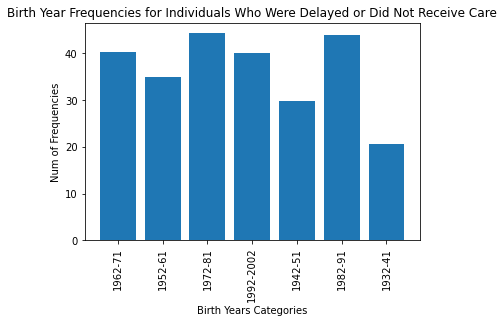

In [6]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

birth_years = ["1962-71", "1952-61", "1972-81", "1992-2002", "1942-51", "1982-91", "1932-41"]
percentages = myutils.percentage_of_population(overall_table.data, delayed_or_none.data, 1)

items = list(percentages.values())
for i in range(len(items)):
    items[i] = items[i] * 100

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(birth_years, items, "Birth Years Categories", "Num of Frequencies", "Birth Year Frequencies for Individuals Who Were Delayed or Did Not Receive Care")

After taking the percentage of each birth decade within the dataset who were denied or delayed healthcare, it was interesting to see that individuals born in the decades 1972-81 and 1982-91 were most likely to be delayed or denied healthcare. While there is no obvious reason for this preliminary relationship, it is possible that accessibility to healthcare was easier for individuals who are much older, due to the increased risk they have if they contract COVID-19.

### Percentage of Population of Each Race and Ethnicity and Accessibility to Healthcare

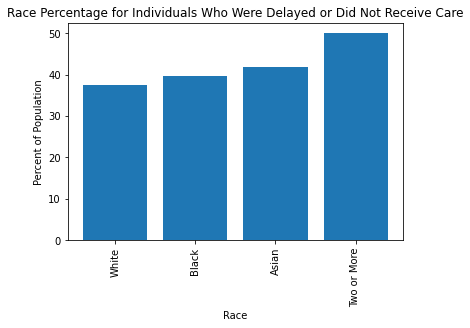

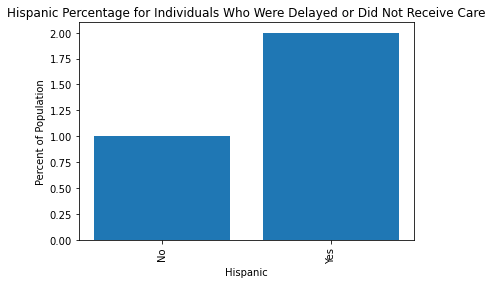

In [7]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Race
race_labels = ["White", "Black", "Asian", "Two or More"]
percentages = myutils.percentage_of_population(overall_table.data, delayed_or_none.data, 4)

items = list(percentages.values())
for i in range(len(items)):
    items[i] = items[i] * 100

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(race_labels, items, "Race", "Percent of Population", "Race Percentage for Individuals Who Were Delayed or Did Not Receive Care")


# Ethnicity (Hispanic)
hispanic_labels = ["No", "Yes"]
percentages = myutils.percentage_of_population(overall_table.data, delayed_or_none.data, 3)

items = list(percentages.values())
for i in range(len(items)):
    items[i] = items[i] * 100

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(hispanic_labels, percentages, "Hispanic", "Percent of Population", "Hispanic Percentage for Individuals Who Were Delayed or Did Not Receive Care")

After taking the percentage of each race and ethinicity, there was unfortunately a clear difference between the races and/or ethincity and the accessibility to healthcare. According to the graphs above, individuals who identify as two or more races and individuals who are hispanic are more likely to be denied or delayed healthcare. These results were a bit more understandable, unfortunately, due the social issue regarding disparities between races and accessibility to different human necessities.

### Percentage of Population Within Each Sex and Accessibility to Healthcare

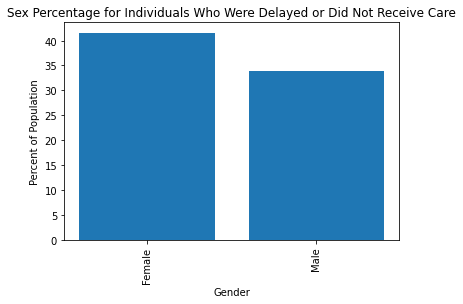

In [8]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Gender/Sex
sex_labels = ["Female", "Male"]
percentages = myutils.percentage_of_population(overall_table.data, delayed_or_none.data, 2)

items = list(percentages.values())
for i in range(len(items)):
    items[i] = items[i] * 100

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(sex_labels, items, "Gender", "Percent of Population", "Sex Percentage for Individuals Who Were Delayed or Did Not Receive Care")

After taking the percentage of each sex/gender, it is evident that women were more likely to be denied or delayed healthcare. Like the previous attributes, this result is unfortunately reasonable, again due to the social dispartities between men and women. It is also important to note that the only values for this attribute were "Female" and "Male" so there is no information regarding individuals who are transgender who also may be present in the dataset. 

### Percentage of Population Who Have Received Different Education Levels and Accessibility to Healthcare

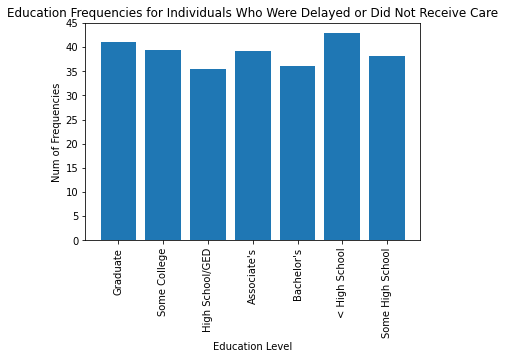

In [9]:
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

# Education
ed_labels = ["Graduate", "Some College", "High School/GED", "Associate's", "Bachelor's", "< High School", "Some High School"]
percentages = myutils.percentage_of_population(overall_table.data, delayed_or_none.data, 5)

items = list(percentages.values())
for i in range(len(items)):
    items[i] = items[i] * 100

# plot a bar graph for each subtable to compare which age groups were more likely to receive care, and which were more likely to be denied
plot_utils.plot_bar(ed_labels, items, "Education Level", "Num of Frequencies", "Education Frequencies for Individuals Who Were Delayed or Did Not Receive Care")

Lastly, after taking the percentage of each education level, it seems that individuals who received less than a high school level of education are more likely to be denied or delayed healthcare during the COVID-19 pandemic. While no research was done to determine the cause of this result, it could be guessed that individuals who have less than a high school level of education may not have access to jobs that will provide healthcare or a variety or socioeconomic reasons.

# Classification
First we will break the information into the appropriate format

In [11]:
# Break information into X_train and class_label
X_train = overall_table.get_columns(["TBIRTH_YEAR", "EGENDER", "RHISPANIC", "RRACE", "EEDUC", "INCOME"])
X_train = X_train.data
Y_train = overall_table.get_column("DELAYNOTGET")

### Process
To find the best classifier, we first computed 2 baseline classifiers, ZeroR and random. We then tested naive bayes, decision tree, and random forest classifiers and looked at how they compared to the baselines and each other. All of these classifiers were loosley based on the sklearn implementation, but featured simpler algorithms made by the authors and less optimization (https://scikit-learn.org/stable/).

### Evaluation
To determine which classifier was the best, we ran each of them over a stratified 10-fold cross validation testing technique for accuracy. The exception was the random forest classifier, which required its own unique approach. We then plugged these results into a confusion matrix to determine if the classifier was better at one or another prediction. Given roughly equal accuracy (within about 1%), the classifier where the recognition rates of all class labels were closer to being the same won out. Meaning any classifier which at least matched the zero R classifier in accuracy, but didn't have a 0%, 100% split in recognition rates, would win out.

## Compute the Baseline
First we will compute the baseline classifiers to get an idea of how must we must improve our classifiers.
### Zero R

In [12]:
print('''===========================================
Predictive Accuracy
===========================================
Stratified 10-Fold Cross Validation''')
k = 10
all_predicted_delay_zero = []
all_actual_delay_zero = []

# Get training data
train_folds, test_folds = myevaluation.stratified_kfold_cross_validation(X_train, Y_train, k)
for i in range(k):
    # Sort training data
    xtrain = myutils.distribute_data_by_index(X_train, train_folds[i])
    ytrain = myutils.distribute_data_by_index(Y_train, train_folds[i])
    xtest = myutils.distribute_data_by_index(X_train, test_folds[i])
    ytest = myutils.distribute_data_by_index(Y_train, test_folds[i])

    # Compute prediction and convert
    zero = MyZeroRClassifier()
    zero.fit(xtrain, ytrain)
    predicted_delay = zero.predict(xtest)
    all_predicted_delay_zero += predicted_delay
    all_actual_delay_zero += ytest
    
# Calculate overall accuracy
accuracy = myutils.calculate_accuracy(all_predicted_delay_zero, all_actual_delay_zero)
error_rate = 1- accuracy

print("Zero R: accuracy = " + str(accuracy) + ", error rate = " + str(error_rate))

Predictive Accuracy
Stratified 10-Fold Cross Validation
Zero R: accuracy = 0.614735226400614, error rate = 0.38526477359938605


In [13]:
print('''===========================================
Confusion Matrices
===========================================
Zero R (Stratified 10-Fold Cross Validation):''')

ylabels = list(set(Y_train))
matrix = myevaluation.confusion_matrix(all_actual_delay_zero, all_predicted_delay_zero, ylabels)
header = myutils.format_confusion_matrix_into_table(matrix, ["Delayed/canceled", "Not delayed"], "Delayed/canceled")

print(tabulate(matrix, headers=header, tablefmt="rst", numalign="right"))

Confusion Matrices
Zero R (Stratified 10-Fold Cross Validation):
==================  ==================  =============  =======  =================
Delayed/canceled      Delayed/canceled    Not delayed    Total    Recognition (%)
==================  ==================  =============  =======  =================
Delayed/canceled                     0           1506     1506                  0
Not delayed                          0           2403     2403                100
==================  ==================  =============  =======  =================


### Random Classifier

In [14]:
print('''===========================================
Predictive Accuracy
===========================================
Stratified 10-Fold Cross Validation''')
k = 10
all_predicted_delay_random = []
all_actual_delay_random = []

# Get training data
train_folds, test_folds = myevaluation.stratified_kfold_cross_validation(X_train, Y_train, k)
for i in range(k):
    # Sort training data
    xtrain = myutils.distribute_data_by_index(X_train, train_folds[i])
    ytrain = myutils.distribute_data_by_index(Y_train, train_folds[i])
    xtest = myutils.distribute_data_by_index(X_train, test_folds[i])
    ytest = myutils.distribute_data_by_index(Y_train, test_folds[i])

    # Compute prediction and convert
    random = MyRandomClassifier()
    random.fit(xtrain, ytrain)
    predicted_delay = random.predict(xtest)
    all_predicted_delay_random += predicted_delay
    all_actual_delay_random += ytest
    
# Calculate overall accuracy
accuracy = myutils.calculate_accuracy(all_predicted_delay_random, all_actual_delay_random)
error_rate = 1- accuracy

print("Random: accuracy = " + str(accuracy) + ", error rate = " + str(error_rate))

Predictive Accuracy
Stratified 10-Fold Cross Validation
Random: accuracy = 0.5262215400358148, error rate = 0.4737784599641852


In [15]:
print('''===========================================
Confusion Matrices
===========================================
Random (Stratified 10-Fold Cross Validation):''')

ylabels = list(set(Y_train))
matrix = myevaluation.confusion_matrix(all_actual_delay_random, all_predicted_delay_random, ylabels)
header = myutils.format_confusion_matrix_into_table(matrix, ["Delayed/canceled", "Not delayed"], "Delayed/canceled")

print(tabulate(matrix, headers=header, tablefmt="rst", numalign="right"))

Confusion Matrices
Random (Stratified 10-Fold Cross Validation):
==================  ==================  =============  =======  =================
Delayed/canceled      Delayed/canceled    Not delayed    Total    Recognition (%)
==================  ==================  =============  =======  =================
Delayed/canceled                   580            926     1506              38.51
Not delayed                        926           1477     2403              61.46
==================  ==================  =============  =======  =================


## Compute Actual Classifiers
Next we try running naive bayes, decision tree, and random forest classifiers over our database and see how they compare.

### Naive Bayes

In [16]:
print('''===========================================
Predictive Accuracy
===========================================
Stratified 10-Fold Cross Validation''')
k = 10
all_predicted_delay_bayes = []
all_actual_delay_bayes = []

# Get training data
train_folds, test_folds = myevaluation.stratified_kfold_cross_validation(X_train, Y_train, k)
for i in range(k):
    # Sort training data
    xtrain = myutils.distribute_data_by_index(X_train, train_folds[i])
    ytrain = myutils.distribute_data_by_index(Y_train, train_folds[i])
    xtest = myutils.distribute_data_by_index(X_train, test_folds[i])
    ytest = myutils.distribute_data_by_index(Y_train, test_folds[i])

    # Compute prediction and convert
    bayes = MyNaiveBayesClassifier()
    bayes.fit(xtrain, ytrain)
    predicted_delay = bayes.predict(xtest)
    all_predicted_delay_bayes += predicted_delay
    all_actual_delay_bayes += ytest
    
# Calculate overall accuracy
accuracy = myutils.calculate_accuracy(all_predicted_delay_bayes, all_actual_delay_bayes)
error_rate = 1- accuracy

print("Naive bayes: accuracy = " + str(accuracy) + ", error rate = " + str(error_rate))

Predictive Accuracy
Stratified 10-Fold Cross Validation
Naive bayes: accuracy = 0.6144794064978255, error rate = 0.3855205935021745


In [17]:
print('''===========================================
Confusion Matrices
===========================================
Naive bayes (Stratified 10-Fold Cross Validation):''')

ylabels = list(set(Y_train))
matrix = myevaluation.confusion_matrix(all_actual_delay_bayes, all_predicted_delay_bayes, ylabels)
header = myutils.format_confusion_matrix_into_table(matrix, ["Delayed/canceled", "Not delayed"], "Delayed/canceled")

print(tabulate(matrix, headers=header, tablefmt="rst", numalign="right"))

Confusion Matrices
Naive bayes (Stratified 10-Fold Cross Validation):
==================  ==================  =============  =======  =================
Delayed/canceled      Delayed/canceled    Not delayed    Total    Recognition (%)
==================  ==================  =============  =======  =================
Delayed/canceled                   221           1285     1506              14.67
Not delayed                        222           2181     2403              90.76
==================  ==================  =============  =======  =================


Naive Bayes had comparable accuracy to the Zero R classifier, as well as better delayed/canceled recognition. It also has better accuracy, and worse recognition than the random classifier.

### Decision Tree

In [18]:
print('''===========================================
Predictive Accuracy
===========================================
Stratified 10-Fold Cross Validation''')
k = 10
all_predicted_delay_tree = []
all_actual_delay_tree = []

# Get training data
train_folds, test_folds = myevaluation.stratified_kfold_cross_validation(X_train, Y_train, k)
for i in range(k):
    # Sort training data
    xtrain = myutils.distribute_data_by_index(X_train, train_folds[i])
    ytrain = myutils.distribute_data_by_index(Y_train, train_folds[i])
    xtest = myutils.distribute_data_by_index(X_train, test_folds[i])
    ytest = myutils.distribute_data_by_index(Y_train, test_folds[i])

    # Compute prediction and convert
    tree = MyDecisionTreeClassifier()
    tree.fit(xtrain, ytrain, ['RHISPANIC', 'RRACE', 'TBIRTH_YEAR', 'INCOME', 'label'])
    predicted_delay = tree.predict(xtest)
    all_predicted_delay_tree += predicted_delay
    all_actual_delay_tree += ytest
# Calculate overall accuracy
accuracy = myutils.calculate_accuracy(all_predicted_delay_tree, all_actual_delay_tree)
error_rate = 1- accuracy

print("Decision Tree: accuracy = " + str(accuracy) + ", error rate = " + str(error_rate))

Predictive Accuracy
Stratified 10-Fold Cross Validation
Decision Tree: accuracy = 0.6091071885392684, error rate = 0.3908928114607316


In [19]:
print('''===========================================
Confusion Matrices
===========================================
Decision Tree (Stratified 10-Fold Cross Validation):''')

ylabels = list(set(Y_train))
matrix = myevaluation.confusion_matrix(all_actual_delay_tree, all_predicted_delay_tree, ylabels)
header = myutils.format_confusion_matrix_into_table(matrix, ["Delayed/canceled", "Not delayed"], "Delayed/canceled")

print(tabulate(matrix, headers=header, tablefmt="rst", numalign="right"))

Confusion Matrices
Decision Tree (Stratified 10-Fold Cross Validation):
==================  ==================  =============  =======  =================
Delayed/canceled      Delayed/canceled    Not delayed    Total    Recognition (%)
==================  ==================  =============  =======  =================
Delayed/canceled                   157           1349     1506              10.42
Not delayed                        179           2224     2403              92.55
==================  ==================  =============  =======  =================


The decision tree, as you can see, did not have very good performance. It was out performed slightly by the zero R and Naive Bayes classifiers in terms of accuracy only had the benefit of better delayed/canceled recognition. The best accuracy results were found using hispanic, race, birth year, and income. Adding gender and education decreased accuracy and increased delayed/canceled recognition. With the current structure it has almost identical performance to the Naive Bayes classifier, if slightly less good. In accuracy it still outperformed the random classifier, though did worse in delayed/canceled recognition.

### Random Forest 
With the forest classifier we had to use a different method of evaluation due to the randomness that it featured. To do this we followed the random forest procedure described in class (located at https://github.com/GonzagaCPSC322/U7-Ensemble-Learning/blob/master/A%20Ensemble%20Learning.ipynb). We computed a stratified k fold cross validation with k=3. Then we selected one of the folds as our validation set, and the rest as our training set. We trained the forest over the training set, then tested it against the validation set. This was done 5 times to attempt to minimize the effects of randomness in evaluating the classifier. We then computed the overall accuracy and confusion matrixes, and continued as normal in our evaluation. Additionally, we varied the values of N, M, and F to see if they had an effect on accuracy

In [20]:
N = 10
M = 5
F = 1

print('''===========================================
Predictive Accuracy
===========================================''')
print("Individual Tree Accuracy:")
all_predicted_forest = []
all_actual_forest = []
# Run tests of each parameter 5 times
for i in range(5):
    forest = MyRandomForestClassifier(N, F, M)
    accuracy, predicted, actual = forest.test_tree_stratified_kfold(X_train, Y_train)
    all_predicted_forest += predicted
    all_actual_forest += actual
    
    # Print off each trees individual validation acccuracy
    for tree in forest.chosen_trees:
        print("Tree attributes: " + str(tree['attributes']) + ", validation accuracy: " + str(tree['accuracy']))
    
accuracy = myutils.calculate_accuracy(all_predicted_forest, all_actual_forest)
error_rate = 1- accuracy
print('''===========================================
Predictive Accuracy
===========================================
Stratified 3-Fold Cross Validation''')
print("Forest: accuracy = " + str(accuracy) + ", error rate = " + str(error_rate))
print('''Confusion Matrices:''')

ylabels = list(set(Y_train))
matrix = myevaluation.confusion_matrix(all_actual_delay_tree, all_predicted_delay_tree, ylabels)
header = myutils.format_confusion_matrix_into_table(matrix, ["Delayed/canceled", "Not delayed"], "Delayed/canceled")

print(tabulate(matrix, headers=header, tablefmt="rst", numalign="right"))

Predictive Accuracy
Individual Tree Accuracy:
Tree attributes: ['a1'], validation accuracy: 0.6302521008403361
Tree attributes: ['a1'], validation accuracy: 0.6252699784017278
Tree attributes: ['a3'], validation accuracy: 0.6237006237006237
Tree attributes: ['a3'], validation accuracy: 0.6216216216216216
Tree attributes: ['a2'], validation accuracy: 0.6203605514316013
Tree attributes: ['a3'], validation accuracy: 0.6363636363636364
Tree attributes: ['a1'], validation accuracy: 0.6346555323590815
Tree attributes: ['a3'], validation accuracy: 0.6334340382678751
Tree attributes: ['a4'], validation accuracy: 0.6253838280450358
Tree attributes: ['a0'], validation accuracy: 0.6247422680412371
Tree attributes: ['a3'], validation accuracy: 0.6294363256784968
Tree attributes: ['a1'], validation accuracy: 0.6229508196721312
Tree attributes: ['a1'], validation accuracy: 0.6209081309398099
Tree attributes: ['a5'], validation accuracy: 0.6190975865687304
Tree attributes: ['a1'], validation accuracy

In [21]:
N = 10
M = 5
F = 4

print('''===========================================
Predictive Accuracy
===========================================''')
print("Individual Tree Accuracy:")
all_predicted_forest = []
all_actual_forest = []
# Run tests of each parameter 5 times
for i in range(5):
    forest = MyRandomForestClassifier(N, F, M)
    accuracy, predicted, actual = forest.test_tree_stratified_kfold(X_train, Y_train)
    all_predicted_forest += predicted
    all_actual_forest += actual
    
    # Print off each trees individual validation acccuracy
    for tree in forest.chosen_trees:
        print("Tree attributes: " + str(tree['attributes']) + ", validation accuracy: " + str(tree['accuracy']))
    
accuracy = myutils.calculate_accuracy(all_predicted_forest, all_actual_forest)
error_rate = 1- accuracy
print('''===========================================
Predictive Accuracy
===========================================
Stratified 3-Fold Cross Validation''')
print("Forest: accuracy = " + str(accuracy) + ", error rate = " + str(error_rate))
print('''Confusion Matrices:''')

ylabels = list(set(Y_train))
matrix = myevaluation.confusion_matrix(all_actual_delay_tree, all_predicted_delay_tree, ylabels)
header = myutils.format_confusion_matrix_into_table(matrix, ["Delayed/canceled", "Not delayed"], "Delayed/canceled")

print(tabulate(matrix, headers=header, tablefmt="rst", numalign="right"))

Predictive Accuracy
Individual Tree Accuracy:
Tree attributes: ['a0', 'a2', 'a1', 'a4'], validation accuracy: 0.6314168377823408
Tree attributes: ['a1', 'a4', 'a0', 'a5'], validation accuracy: 0.6303664921465969
Tree attributes: ['a4', 'a3', 'a2', 'a1'], validation accuracy: 0.6236673773987207
Tree attributes: ['a2', 'a3', 'a4', 'a5'], validation accuracy: 0.6132368148914168
Tree attributes: ['a4', 'a3', 'a1', 'a2'], validation accuracy: 0.6069958847736625
Tree attributes: ['a3', 'a5', 'a1', 'a2'], validation accuracy: 0.629746835443038
Tree attributes: ['a0', 'a4', 'a2', 'a3'], validation accuracy: 0.621822033898305
Tree attributes: ['a5', 'a2', 'a3', 'a0'], validation accuracy: 0.6212590299277606
Tree attributes: ['a4', 'a5', 'a3', 'a0'], validation accuracy: 0.6197916666666666
Tree attributes: ['a2', 'a5', 'a3', 'a0'], validation accuracy: 0.6171792152704135
Tree attributes: ['a5', 'a0', 'a3', 'a2'], validation accuracy: 0.6296296296296297
Tree attributes: ['a5', 'a0', 'a4', 'a1'], 

Increasing F seems to have only decreased the accuracy of the classifier.

In [22]:
N = 20
M = 5
F = 2

print('''===========================================
Predictive Accuracy
===========================================''')
print("Individual Tree Accuracy:")
all_predicted_forest = []
all_actual_forest = []
# Run tests of each parameter 5 times
for i in range(5):
    forest = MyRandomForestClassifier(N, F, M)
    accuracy, predicted, actual = forest.test_tree_stratified_kfold(X_train, Y_train)
    all_predicted_forest += predicted
    all_actual_forest += actual
    
    # Print off each trees individual validation acccuracy
    for tree in forest.chosen_trees:
        print("Tree attributes: " + str(tree['attributes']) + ", validation accuracy: " + str(tree['accuracy']))
    
accuracy = myutils.calculate_accuracy(all_predicted_forest, all_actual_forest)
error_rate = 1- accuracy
print('''===========================================
Predictive Accuracy
===========================================
Stratified 3-Fold Cross Validation''')
print("Forest: accuracy = " + str(accuracy) + ", error rate = " + str(error_rate))
print('''Confusion Matrices:''')

ylabels = list(set(Y_train))
matrix = myevaluation.confusion_matrix(all_actual_delay_tree, all_predicted_delay_tree, ylabels)
header = myutils.format_confusion_matrix_into_table(matrix, ["Delayed/canceled", "Not delayed"], "Delayed/canceled")

print(tabulate(matrix, headers=header, tablefmt="rst", numalign="right"))

Predictive Accuracy
Individual Tree Accuracy:
Tree attributes: ['a0', 'a1'], validation accuracy: 0.6343519494204426
Tree attributes: ['a4', 'a2'], validation accuracy: 0.6296296296296297
Tree attributes: ['a4', 'a1'], validation accuracy: 0.6275720164609053
Tree attributes: ['a0', 'a1'], validation accuracy: 0.6251287332646756
Tree attributes: ['a0', 'a4'], validation accuracy: 0.6239406779661016
Tree attributes: ['a0', 'a3'], validation accuracy: 0.6206896551724138
Tree attributes: ['a0', 'a5'], validation accuracy: 0.619914346895075
Tree attributes: ['a3', 'a0'], validation accuracy: 0.6198179979777553
Tree attributes: ['a0', 'a1'], validation accuracy: 0.6197033898305084
Tree attributes: ['a3', 'a4'], validation accuracy: 0.6157894736842106
Tree attributes: ['a4', 'a3'], validation accuracy: 0.6371134020618556
Tree attributes: ['a1', 'a3'], validation accuracy: 0.6284501061571125
Tree attributes: ['a0', 'a1'], validation accuracy: 0.6261306532663317
Tree attributes: ['a0', 'a3'], v

Increasing M seems to have marginally increased the accuracy, but not significantly

In [23]:
N = 20
M = 2
F = 1

print('''===========================================
Predictive Accuracy
===========================================''')
print("Individual Tree Accuracy:")
all_predicted_forest = []
all_actual_forest = []
# Run tests of each parameter 5 times
for i in range(5):
    forest = MyRandomForestClassifier(N, F, M)
    accuracy, predicted, actual = forest.test_tree_stratified_kfold(X_train, Y_train)
    all_predicted_forest += predicted
    all_actual_forest += actual
    
    # Print off each trees individual validation acccuracy
    for tree in forest.chosen_trees:
        print("Tree attributes: " + str(tree['attributes']) + ", validation accuracy: " + str(tree['accuracy']))
    
accuracy = myutils.calculate_accuracy(all_predicted_forest, all_actual_forest)
error_rate = 1- accuracy
print('''===========================================
Predictive Accuracy
===========================================
Stratified 3-Fold Cross Validation''')
print("Forest: accuracy = " + str(accuracy) + ", error rate = " + str(error_rate))
print('''Confusion Matrices:''')

ylabels = list(set(Y_train))
matrix = myevaluation.confusion_matrix(all_actual_delay_tree, all_predicted_delay_tree, ylabels)
header = myutils.format_confusion_matrix_into_table(matrix, ["Delayed/canceled", "Not delayed"], "Delayed/canceled")

print(tabulate(matrix, headers=header, tablefmt="rst", numalign="right"))

Predictive Accuracy
Individual Tree Accuracy:
Tree attributes: ['a5'], validation accuracy: 0.6371134020618556
Tree attributes: ['a4'], validation accuracy: 0.6357142857142857
Tree attributes: ['a1'], validation accuracy: 0.6399155227032735
Tree attributes: ['a4'], validation accuracy: 0.6375404530744336
Tree attributes: ['a5'], validation accuracy: 0.6374745417515275
Tree attributes: ['a4'], validation accuracy: 0.6352201257861635
Tree attributes: ['a0'], validation accuracy: 0.6299045599151644
Tree attributes: ['a3'], validation accuracy: 0.6265822784810127
Tree attributes: ['a3'], validation accuracy: 0.6265690376569037
Tree attributes: ['a5'], validation accuracy: 0.6239406779661016
Predictive Accuracy
Stratified 3-Fold Cross Validation
Forest: accuracy = 0.614735226400614, error rate = 0.38526477359938605
Confusion Matrices:
==================  ==================  =============  =======  =================
Delayed/canceled      Delayed/canceled    Not delayed    Total    Recognitio

Decreasing the M value also did not noticeably modify the results.

As such the best combination seems to have F=1, with M and N not having as much of an effect.

## Results
The forest classifier accuracy outperformed all the other classifiers. In terms of accuracy it beat Naive Bayes, Decision Tree, and Random classifiers. It was on par with the zero R classifier, but had a better Delayed/canceled recognition rate. It didn't have as good a delayed/canceled recognition rate as random did, but it was significantly more accurate, making it still the better choice. As such it was the best. 

That said it was not a particularly good classifier. It only managed to be on par with the zero R classifier in terms of accuracy, and only counted as a better algorithm because its delayed/canceled recognition rate was superior to zero R's. More work would be required for it to be utilized in an important role.

### Heroku
Here we will store the last tree we made with one of the better results.

To test, type in the following url (TODO change to heroku): http://127.0.0.1:5000/predict?birth_year=1993&gender=2&hispanic=1&race=3&income=4&education=7  
You can then modify the values and see what it predicts. Reference the introduction section where all of these are explained to determine what numbers you should place. Invalid numbers will not be accepted.

In [24]:
import pickle
trees = forest.chosen_trees
package = []
for tree in trees:
    package.append([tree['tree'].tree, tree['tree'].header])
print(package)
pickle_path = "forest_pickler.py"
outfile = open(pickle_path, "wb")
pickle.dump(package, outfile)
outfile.close()

[[['Attribute', 'a3', ['Value', 5, ['Leaf', 2, 460, 2606]], ['Value', 3, ['Leaf', 2, 604, 2606]], ['Value', 1, ['Leaf', 2, 78, 2606]], ['Value', 4, ['Leaf', 2, 536, 2606]], ['Value', 2, ['Leaf', 2, 355, 2606]], ['Value', 7, ['Leaf', 2, 151, 2606]], ['Value', 6, ['Leaf', 2, 422, 2606]]], ['a3', 'label']], [['Attribute', 'a5', ['Value', 5, ['Leaf', 2, 493, 2606]], ['Value', 3, ['Leaf', 2, 621, 2606]], ['Value', 4, ['Leaf', 2, 481, 2606]], ['Value', 6, ['Leaf', 2, 419, 2606]], ['Value', 2, ['Leaf', 2, 366, 2606]], ['Value', 7, ['Leaf', 2, 154, 2606]], ['Value', 1, ['Leaf', 2, 72, 2606]]], ['a5', 'label']]]


# Conclusion

Overall the project was moderately successful. We started with a dataset with a number of demographic and socioeconomic attributes, and whether or not individuals suffered delayed or canceled care due to COVID-19. Ounce we found the correct dataset, we were able to relatively easily use part of that data for classification. We approached our classifiers by creating two baseline ones, then testing three others against those baselines to determine how effective they were. Our best classifier, the random forest, had comparable accuracy to the first baseline classifier with better recognition rates, and outperformed the second baseline classifier by a notable amount in accuracy. However, these results were not ideal, and future development would be needed before the classifier could be useful. 

Future work might try predicting based on other attributes that were included in the general dataset. Employment status, other health related information, housing status, or any number of elements may have a stronger correlation. Atlernatively, the correlations of some attributes may be greater in certain areas, such as race mattering in some states more than others. Finally, it should be noted that the current classifier utilized only about 3000 of the ~70,000 data points available in one week of a study that has been going along for at least 27 weeks due to runtime issues. Utilizing more computer power and optimized algorithms to process all of the data might reveal that the current snapshot was not representative of the whole, and should definitely be investigated.